In [220]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import os
import meshio
import math
import sys
from matplotlib.patches import Polygon
import matplotlib.cm as cm  # Importar módulo de colormap
from Quad9 import Quad9
from Node import Node
from units import mm, cm, m, kgf, N, tf, kN, MPa, GPa
from fem import Material
from Membrane import Membrane
from functions import matrix_extract,  get_nodes_from_physical_id, get_line_load_global_vector, matrix_replace

In [221]:
output_file = "mallas/malla_quad9.msh"   #cambiar el numero de la malla --> malla_quad4G1.msh, malla_quad4G2.msh, malla_quad4G3.msh, malla_quad4G4.msh, malla_quad4L1.msh,....
titulo = "Quad 4 Local refinement case 4"#"Quad 9 Global refinement case 1" #Cambiar el numero y G-->L

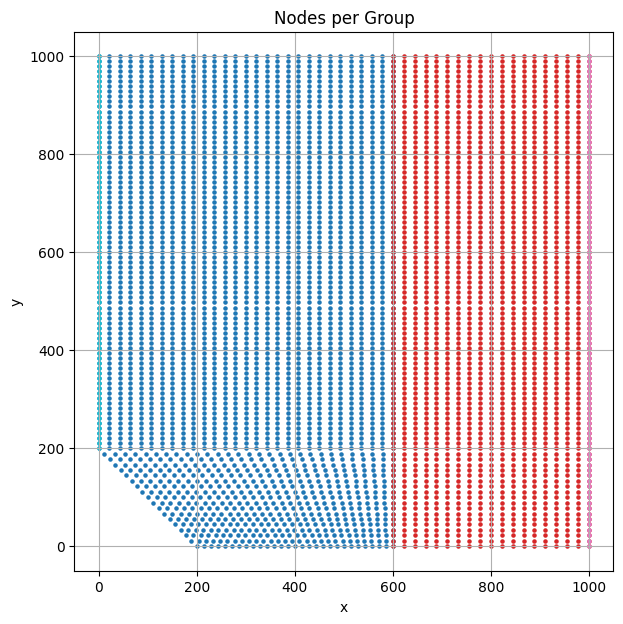

In [222]:
import meshio
import numpy as np
from collections import defaultdict
from Node import Node  # Asegúrate que Node tenga `.index`, `.coord`, `.restrain` y `plot_nodes_por_grupo`

def make_nodes_groups_quad9(output_file, title):
    mesh = meshio.read(output_file)
    
    tag_to_name = {v[0]: k for k, v in mesh.field_data.items()}
    grupos = defaultdict(dict)  # nombre_grupo: {id_nodo: Node}

    # Procesar elementos tipo quad9
    for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
        if cell_block.type != "quad9":
            continue
        for quad, tag in zip(cell_block.data, phys_tags):
            nombre = tag_to_name.get(tag, str(tag))
            for node_id in quad:
                x, y = mesh.points[node_id][:2]
                if node_id not in grupos[nombre]:
                    grupos[nombre][node_id] = Node(node_id + 1, [x, y])

    # Procesar líneas tipo line3 para condiciones de borde
    for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
        if cell_block.type != "line3":
            continue
        for line, tag in zip(cell_block.data, phys_tags):
            nombre = tag_to_name.get(tag, str(tag))
            for node_id in line:
                x, y = mesh.points[node_id][:2]
                restrain = [0, 0]
                if nombre == "BC_R1":
                    restrain = [1, 0]
                if np.isclose(x, 1000) and np.isclose(y, 1000):
                    restrain = [1, 1]
                if node_id not in grupos[nombre]:
                    grupos[nombre][node_id] = Node(node_id + 1, [x, y], restrain=restrain)
                else:
                    grupos[nombre][node_id].restrain = restrain  # Actualiza si ya existe

    # Convertir a listas
    grupos_final = {nombre: list(nodos.values()) for nombre, nodos in grupos.items()}

    # Visualizar (si está disponible)
    Node.plot_nodes_por_grupo(grupos_final, title, show_ids=False, save=False)

    return grupos_final, mesh

grupos, mesh = make_nodes_groups_quad9(output_file, "Quad9")

In [223]:


class Membrane:
    def __init__(self, thickness, material):
        self.thickness = thickness
        self.material = material

def make_sections(grupos):
    thickness_dict = {"201": 100, "202": 100,}
    sections = {}

    for group in thickness_dict:
        material = Material.Material(E=200e3, nu=0.36, gamma=7800e-9)
        sections[group] = Membrane(thickness_dict[group], material)

    nodes_dict = {}
    for group in grupos:
        for node in grupos[group]:
            nodes_dict[node.index] = node

    return sections, nodes_dict

sections, nodes_dict = make_sections(grupos)


In [224]:
# Extrae el primer elemento tipo quad9
nodes_mesh = mesh.cells_dict['quad9'][0]

print("Nodos del primer Quad9:")
for i, node_id in enumerate(nodes_mesh):
    global_id = node_id + 1  # Node usa índices base 1
    coord = nodes_dict[global_id].coord
    print(f"  Nodo local {i}: ID global {global_id}, coordenadas = {coord}")

Nodos del primer Quad9:
  Nodo local 0: ID global 1, coordenadas = [np.float64(0.0), np.float64(200.0)]
  Nodo local 1: ID global 10, coordenadas = [np.float64(22.22222222222219), np.float64(177.7777777777778)]
  Nodo local 2: ID global 424, coordenadas = [np.float64(63.49206349206338), np.float64(177.7777777777778)]
  Nodo local 3: ID global 303, coordenadas = [np.float64(42.85714285714285), np.float64(200.0)]
  Nodo local 4: ID global 18, coordenadas = [np.float64(11.11111111111109), np.float64(188.8888888888889)]
  Nodo local 5: ID global 528, coordenadas = [np.float64(42.85714285714278), np.float64(177.7777777777778)]
  Nodo local 6: ID global 529, coordenadas = [np.float64(53.17460317460313), np.float64(188.8888888888889)]
  Nodo local 7: ID global 316, coordenadas = [np.float64(21.42857142857143), np.float64(200.0)]
  Nodo local 8: ID global 530, coordenadas = [np.float64(32.14285714285711), np.float64(188.8888888888889)]


In [225]:
def ordenar_nodos_quad9(nodos):
    """
    Ordena los nodos para un elemento Quad9 de acuerdo con el siguiente patrón:
    
    1 -- 5 -- 2
    |    |    |
    8 -- 9 -- 6
    |    |    |
    4 -- 7 -- 3
    """
    if len(nodos) != 9:
        raise ValueError("Se requieren exactamente 9 nodos para un Quad9")

    # Suponiendo que nodos es una lista de objetos Node, y que el orden original puede ser incorrecto
    # El orden debe seguir este patrón
    nodo_ordenado = [
        nodos[0],  # Nodo 1
        nodos[4],  # Nodo 5
        nodos[1],  # Nodo 2
        nodos[7],  # Nodo 8
        nodos[8],  # Nodo 9
        nodos[5],  # Nodo 6
        nodos[3],  # Nodo 4
        nodos[6],  # Nodo 7
        nodos[2]   # Nodo 3
    ]
    
    return nodo_ordenado


In [226]:
import numpy as np
from itertools import permutations

def verificar_y_reordenar_nodos(nodos, quad9_element):
    """
    Verifica el Jacobiano de un elemento Quad9. Si el Jacobiano es negativo,
    intenta reordenar los nodos hasta que el Jacobiano sea positivo.
    
    Args:
        nodos (list): Lista de nodos del elemento Quad9.
        quad9_element (Quad9): Objeto de la clase Quad9 para calcular el Jacobiano.
    
    Returns:
        nodos_reordenados (list): Lista de nodos, posiblemente reordenados.
        es_valido (bool): Si el Jacobiano es positivo y la geometría es válida.
    """
    # Evaluar el Jacobiano con el orden actual de nodos
    _, _, J_det, _ = quad9_element.calculate_B_matrix(0, 0)  # Evaluamos el Jacobiano en el punto (0, 0)
    
    if J_det > 0:
        # Si el Jacobiano es positivo, no es necesario hacer nada
        return nodos, True
    else:
        # Intentamos reordenar los nodos para encontrar una orientación válida
        print("⚠️ Jacobiano negativo. Intentando reordenar los nodos.")
        
        # Probamos con las permutaciones de los nodos
        for perm in permutations(nodos):
            # Evaluar el Jacobiano para cada permutación
            quad9_element.node_list = perm  # Asignamos la permutación a los nodos del objeto
            _, _, J_det, _ = quad9_element.calculate_B_matrix(0, 0)  # Evaluamos nuevamente con la permutación
            
            if J_det > 0:
                print("✅ Jacobiano positivo encontrado tras reordenar los nodos.")
                return perm, True
        
        # Si ningún reordenamiento da un Jacobiano positivo
        print("❌ No se pudo encontrar un orden válido para los nodos.")
        return nodos, False


In [227]:
def make_quad9_elements(mesh, sections, nodes_dict):
    quads = mesh.cells_dict.get('quad9', [])
    tags = mesh.cell_data_dict["gmsh:physical"].get("quad9", [])
    elements = []
    used_nodes = set()
    nodos_faltantes = []
    errores_jacobiano = []

    for i in range(len(tags)):
        section_tag = str(tags[i])
        if section_tag not in sections:
            print(f"⚠️ Tag físico {section_tag} no tiene sección asociada. Elemento {i + 1} omitido.")
            continue

        section = sections[section_tag]
        node_ids = quads[i]

        try:
            nodos = [nodes_dict[node_id + 1] for node_id in node_ids]
        except KeyError as e:
            nodos_faltantes.append(node_ids)
            print(f"❌ Nodo no encontrado en nodes_dict: {e}")
            continue

        for nodo in nodos:
            used_nodes.add(nodo)

        # Intentamos crear el elemento y capturamos errores de Jacobiano
        try:
            element = Quad9(i + 1, nodos, section)
            elements.append(element)
        except ValueError as ve:
            print(f"❌ Error en el elemento {i + 1} con Jacobiano no positivo:")
            print(f"   Nodos: {[n.index for n in nodos]}")
            print(f"   Coordenadas:")
            for j, n in enumerate(nodos):
                print(f"     Nodo local {j}: ID {n.index}, coord = {n.coord}")
            errores_jacobiano.append(i + 1)
            continue

    if nodos_faltantes:
        print(f"❌ Se omitieron {len(nodos_faltantes)} elementos por nodos faltantes.")
    if errores_jacobiano:
        print(f"⚠️ Se omitieron {len(errores_jacobiano)} elementos por Jacobiano negativo.")

    return elements, list(used_nodes)


# Uso:
elements, nodes = make_quad9_elements(mesh, sections, nodes_dict)

❌ Error en el elemento 127 con Jacobiano no positivo:
   Nodos: [np.int32(9), np.int32(330), np.int32(883), np.int32(286), np.int32(338), np.int32(947), np.int32(948), np.int32(294), np.int32(949)]
   Coordenadas:
     Nodo local 0: ID 9, coord = [np.float64(600.0), np.float64(200.0)]
     Nodo local 1: ID 330, coord = [np.float64(644.4444444444445), np.float64(200.0)]
     Nodo local 2: ID 883, coord = [np.float64(644.4444444444445), np.float64(177.7777777777778)]
     Nodo local 3: ID 286, coord = [np.float64(600.0), np.float64(177.7777777777778)]
     Nodo local 4: ID 338, coord = [np.float64(622.2222222222222), np.float64(200.0)]
     Nodo local 5: ID 947, coord = [np.float64(644.4444444444445), np.float64(188.8888888888889)]
     Nodo local 6: ID 948, coord = [np.float64(622.2222222222222), np.float64(177.7777777777778)]
     Nodo local 7: ID 294, coord = [np.float64(600.0), np.float64(188.8888888888889)]
     Nodo local 8: ID 949, coord = [np.float64(622.2222222222222), np.float6

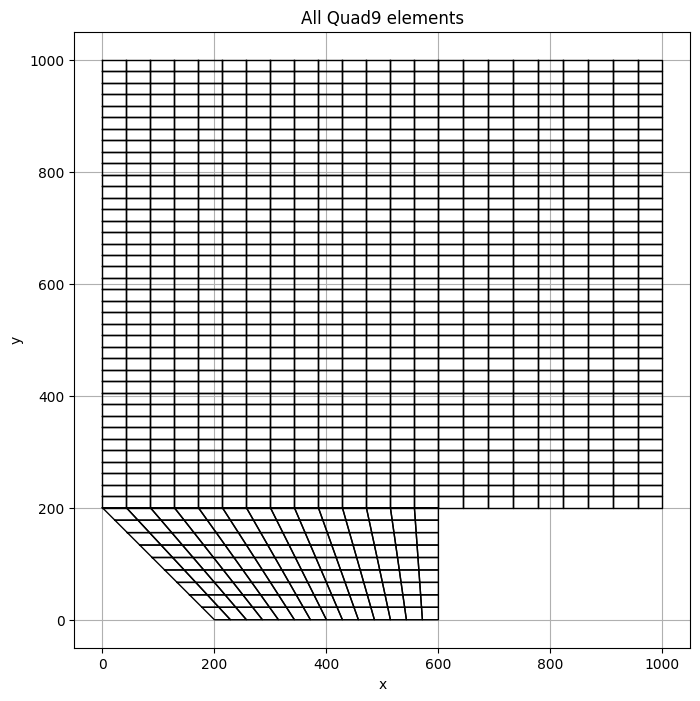

In [228]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_elements_quad9(elements, title, show_ids=True):
    all_x = []
    all_y = []

    for elem in elements:
        coords = elem.xy  # coords.shape = (9, 2)
        
        # Solo usar nodos de esquina para el contorno (0, 1, 2, 3, 0)
        border_nodes = [0, 1, 2, 3, 0]
        coords_border = np.array([coords[i] for i in border_nodes])
        
        all_x.extend(coords_border[:, 0])
        all_y.extend(coords_border[:, 1])

    # Márgenes y dimensiones
    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    x_margin = (x_max - x_min) * 0.05
    y_margin = (y_max - y_min) * 0.05

    x_range = (x_max - x_min) + 2 * x_margin
    y_range = (y_max - y_min) + 2 * y_margin

    fixed_width = 8
    height = fixed_width * (y_range / x_range)

    fig, ax = plt.subplots(figsize=(fixed_width, height))

    for elem in elements:
        coords = elem.xy  # coords.shape = (9, 2)
        
        # Dibujar contorno con nodos de esquina
        border_nodes = [0, 1, 2, 3, 0]
        coords_border = np.array([coords[i] for i in border_nodes])
        ax.plot(coords_border[:, 0], coords_border[:, 1], 'k-', linewidth=1)

        if show_ids:
            for nodo, (x, y) in zip(elem.node_list, coords):
                ax.text(x, y, f'N{nodo.index}', color='black', fontsize=6, ha='center', va='center')

    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.grid(True)

    plt.show()

# Uso:
plot_all_elements_quad9(elements, "All Quad9 elements", show_ids=False)

In [229]:
def solve(nodes, elements):
    """
    Resuelve el sistema FEM considerando cargas distribuidas en líneas.

    Args:
        nodes (list): Lista de nodos con .idx, .nodalLoad, .restrain
        elements (list): Lista de elementos con .kg, .idx
        mesh: Objeto meshio con malla y etiquetas físicas
        load_dictionary (dict): Dict {id_físico: valor_carga}

    Returns:
        u (np.ndarray): Desplazamientos globales
        F_reactions (np.ndarray): Reacciones en DOFs restringidos
        Fj (np.ndarray): Fuerzas nodales aplicadas
        F_total (np.ndarray): Fuerzas totales incluyendo reacciones
    """
    nNodes = len(nodes)
    system_nDof = 2 * nNodes  # 2 DOFs por nodo

    # === CARGAS DISTRIBUIDAS EN LÍNEAS ===
    F_line_global = np.zeros(system_nDof)
    Fj = np.zeros(system_nDof)
    for node in nodes:
        for dof_idx, force in zip(node.idx, node.nodalLoad):
            Fj[dof_idx] = force
  
    # === MATRIZ DE RIGIDEZ GLOBAL ===
    Kg = np.zeros((system_nDof, system_nDof))
    for element in elements:
        Kg = matrix_replace(Kg, element.kg, element.idx, element.idx)


    # === RESTRICCIONES ===
    nodeIndex = np.full(system_nDof, '', dtype=str)
    for node in nodes:
        for dof_idx, status in zip(node.idx, node.restrain):
            nodeIndex[dof_idx] = status

    freeIndices = np.where(nodeIndex == 'f')[0]
    restrainedIndices = np.where(nodeIndex == 'r')[0]
 
    # === PARTICIÓN DEL SISTEMA ===
    Kff = matrix_extract(Kg, freeIndices, freeIndices)
    Kfr = matrix_extract(Kg, freeIndices, restrainedIndices)
    Krf = matrix_extract(Kg, restrainedIndices, freeIndices)
    Krr = matrix_extract(Kg, restrainedIndices, restrainedIndices)

    # === FUERZA TOTAL (aplicada + distribuida) ===
    F = Fj + F_line_global
    Ff = F[freeIndices]
    Fr = F[restrainedIndices]

    # === SOLUCIÓN ===
    uf = np.linalg.solve(Kff, Ff - Kfr @ Fr)
    ur = np.zeros(len(restrainedIndices))

    u = np.zeros(system_nDof)
    u[freeIndices] = uf
    u[restrainedIndices] = ur
    
    # === REACCIONES ===
    Fr = Krf @ uf + Krr @ ur
    F_reactions = np.zeros(system_nDof)
    F_reactions[restrainedIndices] = Fr
    
    return u

In [230]:
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [231]:
def apply_distributed_force(grupo_nodos, fuerza_total):
    """
    Aplica una fuerza distribuida a lo largo de una línea definida por nodos.
    La fuerza total se reparte proporcionalmente según la longitud de cada segmento.

    Args:
        grupo_nodos (list): Lista de nodos (Node) ordenados a lo largo de la línea.
        fuerza_total (float): Fuerza total a repartir (en N o unidades consistentes).
                              Puede estar en cualquier dirección (por ejemplo, solo vertical).
    """
    nodos = grupo_nodos
    n = len(nodos)

    if n < 2:
        print("Se requieren al menos dos nodos para aplicar fuerza distribuida.")
        return

    # Paso 1: calcular longitud total y longitudes de tramos
    longitudes = []
    total_length = 0.0

    for i in range(n - 1):
        dx = nodos[i+1].coordenadas[0] - nodos[i].coordenadas[0]
        dy = nodos[i+1].coordenadas[1] - nodos[i].coordenadas[1]
        L = np.sqrt(dx**2 + dy**2)
        longitudes.append(L)
        total_length += L

    if total_length == 0:
        print("La longitud total es cero, no se puede aplicar la fuerza.")
        return

    # Paso 2: calcular fuerza distribuida por unidad de longitud
    q_lineal = fuerza_total / total_length  # N/m

    # Paso 3: inicializar fuerzas nodales acumuladas
    nodal_forces = {node.name: np.array([0.0, 0.0]) for node in nodos}

    # Paso 4: recorrer cada segmento y distribuir fuerza
    for i in range(n - 1):
        ni = nodos[i]
        nj = nodos[i + 1]
        xi, yi = ni.coordenadas
        xj, yj = nj.coordenadas

        dx = xj - xi
        dy = yj - yi
        L = longitudes[i]

        # Vector unitario del tramo
        tx = dx / L
        ty = dy / L

        # Vector normal (perpendicular)
        nx = 1
        ny = 0  # sentido hacia abajo si horizontal

        # Fuerza total en el tramo
        F_total = q_lineal * L

        # Componentes globales de la fuerza
        fx = F_total * nx
        fy = F_total * ny

        # Distribuir mitad a cada nodo del segmento
        nodal_forces[ni.name] += np.array([fx / 2, fy / 2])
        nodal_forces[nj.name] += np.array([fx / 2, fy / 2])

    # Paso 5: asignar fuerzas a cada nodo
    for node in nodos:
        fx, fy = nodal_forces[node.name]
        node.set_nodalLoad([fx, fy])

In [232]:
def single_force(nodes, grupo_nodos, fuerza_total_y):
    """
    Aplica una fuerza puntual vertical (por ejemplo, peso) sobre un nodo específico.
    La fuerza se descompone en x e y.
    """
    for j in nodes:
        j.set_nodalLoad([0,0])
    # Paso 1: ordena nodos si es necesario (aquí asumimos que ya están ordenados)
    nodos = grupo_nodos


    # Paso 2: escoger un nodo específico (por ejemplo, el primero)
    nodo = nodos[0]  # Cambia esto si deseas otro nodo
    x, y = nodo.coordenadas[0], nodo.coordenadas[1]
    # Paso 3: aplicar carga puntual
    # Fuerza total a aplicar
    F_total = fuerza_total_y  # N
    # Componente de fuerza en x y y (globales)
    fx = 0.0  # Cambia esto si deseas una fuerza en x
    fy = F_total  # Fuerza en y
    nodo.set_nodalLoad([0,-fy])


In [233]:
def apply_distributed_force_especial(grupos, elementos, fuerza_total_x):
    """
    Aplica una fuerza distribuida especial sobre los elementos y carga el peso propio.
    """
    # Itera sobre los elementos
    for element in elementos:
        centroid = element.get_centroid()  # Calcula el centroide del elemento

        # Obtener el área del elemento (debería ser calculada dentro de la clase Quad4)
        area = element.area
        thickness = element.section.thickness / 100  # Asegúrate de que el espesor esté en las unidades correctas
        rho = element.section.material.rho  # Densidad del material

        # Calcular el peso del elemento
        weight = area * thickness * rho * 9.81  # Fuerza por el peso propio (en N)

        # Calcular las fuerzas internas distribuidas por el peso
        F_interna = element.body_weight_forces(x=centroid[0], y=centroid[1], force_vector=[0, weight]) / 4  # Distribuir entre 4 nodos

        # Obtener los nodos del elemento
        node_a, node_b, node_c, node_d = element.node_list

        # Actualizar las cargas nodales
        for node, force in zip([node_a, node_b, node_c, node_d], [F_interna] * 4):
            if node.nodalLoad[0] == 0 and node.nodalLoad[1] == 0:
                node.set_nodalLoad([force[0], -force[1]])
            else:
                node.set_nodalLoad([node.nodalLoad[0] + force[0], node.nodalLoad[1] - force[1]])

    # Aplica la fuerza distribuida a los nodos del grupo "Force"
    if "BC_1" in grupos:
        nodos_fuerza = grupos["BC_1"]

    nodos = nodos_fuerza
    n = len(nodos)

    if n < 2:
        print("Se requieren al menos dos nodos para aplicar fuerza distribuida.")
        return

    # Calcular longitud total de la línea
    longitudes = []
    total_length = 0
    for i in range(n - 1):
        dx = nodos[i+1].coordenadas[0] - nodos[i].coordenadas[0]
        dy = nodos[i+1].coordenadas[1] - nodos[i].coordenadas[1]
        L = np.sqrt(dx**2 + dy**2)
        longitudes.append(L)
        total_length += L

    # Calcular carga distribuida por unidad de longitud
    q_lineal = fuerza_total_x / total_length  # N/m

    # Aplicar cargas parciales a cada nodo
    nodal_forces = {node.name: np.array([0.0, 0.0]) for node in nodos}

    for i in range(n - 1):
        ni = nodos[i]
        nj = nodos[i + 1]
        xi, yi = ni.coordenadas[0], ni.coordenadas[1]
        xj, yj = nj.coordenadas[0], nj.coordenadas[1]

        dx = xj - xi
        dy = yj - yi
        L = longitudes[i]

        # Dirección normalizada del tramo (unitario)
        vx = dx / L
        vy = dy / L

        # Vector perpendicular (hacia la derecha)
        nx = vy
        ny = vx

        # Fuerza total sobre el tramo
        Fi = q_lineal * L  # Total fuerza sobre el tramo

        # Componentes de fuerza en x y y (globales)
        fx = Fi * nx
        fy = Fi * ny

        # Distribuir mitad a cada nodo
        nodal_forces[ni.name] += np.array([fx / 2, fy / 2])
        nodal_forces[nj.name] += np.array([fx / 2, fy / 2])

    # Asignar fuerzas nodales a los nodos
    for node in nodos:
        fx, fy = nodal_forces[node.name]
        f_px, f_py = node.nodalLoad[0], node.nodalLoad[1]
        node.set_nodalLoad([fx + f_px, fy + f_py])


In [234]:
import numpy as np
import matplotlib.pyplot as plt
import os

def compute_stress_strain_components(elements, u):
    results = []
    for elem in elements:
        sigma, epsilon, _ = elem.get_element_stress(u)  # σxx, σyy, σxy
        exx, eyy, exy = epsilon
        sxx, syy, sxy = sigma

        avg_eps = 0.5 * (exx + eyy)
        rad_eps = np.sqrt(((exx - eyy) / 2) ** 2 + exy ** 2)
        eps1 = avg_eps + rad_eps
        eps2 = avg_eps - rad_eps

        avg_sig = 0.5 * (sxx + syy)
        rad_sig = np.sqrt(((sxx - syy) / 2) ** 2 + sxy ** 2)
        sig1 = avg_sig + rad_sig
        sig2 = avg_sig - rad_sig

        results.append({
            "element": elem.element_tag,
            "σxx": sxx, "σyy": syy, "σxy": sxy,
            "εxx": exx, "εyy": eyy, "εxy": exy,
            "σ1": sig1, "σ2": sig2,
            "ε1": eps1, "ε2": eps2
        })
    return results

def ensure_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

def average_element_values_to_nodes(nodes, elements, element_values):
    from collections import defaultdict
    val_sum = defaultdict(float)
    val_count = defaultdict(int)
    for elem, val in zip(elements, element_values):
        for node in elem.node_list:
            val_sum[node.name] += val
            val_count[node.name] += 1
    node_id_to_avg = {
        nid: val_sum[nid] / val_count[nid] for nid in val_sum
    }
    node_id_to_index = {node.name: i for i, node in enumerate(nodes)}
    nodal_values = np.array([
        node_id_to_avg[node.name] for node in nodes
    ])
    return nodal_values

def quad4_to_triangles(elements, node_id_to_index):
    triangles = []
    for elem in elements:
        ids = [node_id_to_index[n.name] for n in elem.node_list]
        triangles.append([ids[0], ids[1], ids[2]])
        triangles.append([ids[0], ids[2], ids[3]])
    return triangles

def plot_scalar_field_on_mesh(nodes, elements, values, title, folder="figuras", filename=None, cmap="viridis"):
    import matplotlib.tri as mtri
    ensure_dir(folder)
    
    node_id_to_index = {node.name: i for i, node in enumerate(nodes)}
    xs = np.array([node.coordenadas[0] for node in nodes])
    ys = np.array([node.coordenadas[1] for node in nodes])
    nodal_values = np.array(values)
    triangles = quad4_to_triangles(elements, node_id_to_index)
    triang = mtri.Triangulation(xs, ys, triangles)

    # Márgenes automáticos
    x_min, x_max = np.min(xs), np.max(xs)
    y_min, y_max = np.min(ys), np.max(ys)
    x_margin = (x_max - x_min) * 0.05
    y_margin = (y_max - y_min) * 0.05
    x_range = (x_max - x_min) + 2 * x_margin
    y_range = (y_max - y_min) + 2 * y_margin
    fixed_width = 8
    height = fixed_width * (y_range / x_range)

    fig, ax = plt.subplots(figsize=(fixed_width, height))
    tcf = ax.tricontourf(triang, nodal_values, levels=20, cmap=cmap)

    cbar = fig.colorbar(tcf, ax=ax)
    cbar.set_label(title)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    ax.set_aspect("equal", adjustable='box')
    ax.grid(True)
    plt.tight_layout()

    if filename is None:
        filename = title.replace(" ", "_").replace("—", "-") + ".png"
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.close()

def plot_all_fields(results, nodes, elements, i):
    fields = ["\u03c3xx", "\u03c3yy", "\u03c3xy", "\u03c31", "\u03c32", "\u03b5xx", "\u03b5yy", "\u03b5xy", "\u03b51", "\u03b52"]
    titles = {
        "\u03c3xx": "Stress σxx", "\u03c3yy": "Stress σyy", "\u03c3xy": "Stress σxy",
        "\u03c31": "Maximum Principal Stress σ1", "\u03c32": "Minimum Principal Stress σ2",
        "\u03b5xx": "Strain εxx", "\u03b5yy": "Strain εyy", "\u03b5xy": "Strain εxy",
        "\u03b51": "Maximum Principal Strain ε1", "\u03b52": "Minimum Principal Strain ε2"
    }
    caso = titulo
    for field in fields:
        element_values = [res[field] for res in results]
        nodal_values = average_element_values_to_nodes(nodes, elements, element_values)
        plot_scalar_field_on_mesh(nodes, elements, nodal_values, f"{caso} — {titles[field]}", folder="Resultados")

In [235]:
def plot_deformed_shape(nodes, elements, u, contador, scale, folder="figuras", title=None):
    """
    Dibuja la estructura deformada y original, marcando nodos cargados y restringidos.

    Args:
        nodes (list): lista de nodos con .coordenadas, .name, .idx
        elements (list): lista de elementos con .node_list
        u (np.ndarray): vector de desplazamientos global
        contador (int): índice del caso (0, 1, 2)
        scale (float): factor de amplificación de la deformación
    """
    filename = None
    # Inicializar vectores de coordenadas
    n = len(nodes)
    x = np.zeros(n)
    y = np.zeros(n)
    x_def = np.zeros(n)
    y_def = np.zeros(n)

    # Construcción coordenadas originales y deformadas usando node.idx
    for i, node in enumerate(nodes):
        x[i] = node.coordenadas[0]
        y[i] = node.coordenadas[1]
        x_def[i] = x[i] + scale * u[node.idx[0]]
        y_def[i] = y[i] + scale * u[node.idx[1]]

    # Mapeo name → índice en array
    node_index_map = {node.name: i for i, node in enumerate(nodes)}

    # Gráfico
    fig, ax = plt.subplots(figsize=(8, 6))

    # Estructura original (negro)
    for elem in elements:
        indices = [node_index_map[node.name] for node in elem.node_list]
        coords = np.array([[x[i], y[i]] for i in indices + [indices[0]]])
        ax.plot(coords[:, 0], coords[:, 1], 'k-', linewidth=1)

    # Estructura deformada (rojo punteado)
    for elem in elements:
        indices = [node_index_map[node.name] for node in elem.node_list]
        coords = np.array([[x_def[i], y_def[i]] for i in indices + [indices[0]]])
        ax.plot(coords[:, 0], coords[:, 1], 'r--', linewidth=1)



    ax.set_title(title)  # Usar 'title' que ya está correctamente asignado
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")

    # Leyenda fuera del gráfico
    ax.legend(
        handles=[
            plt.Line2D([0], [0], color='k', lw=1, label='Element'),
            plt.Line2D([0], [0], linestyle='--', color='r', lw=1, label='Deformada')
        ],
        loc="center left",
        bbox_to_anchor=(1.02, 0.5)
    )

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    ensure_dir(folder)
    if filename is None:
        filename = title.replace(" ", "_").replace("—", "-") + ".png"
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath, dpi=300)


In [236]:
if "BC_1" in grupos:
    nodos_fuerza = grupos["BC_1"]
i=1
apply_distributed_force_especial(grupos, elements, 1500*kN)
u=solve(nodes, elements)
plot_deformed_shape(nodes, elements, u, i, scale=100, folder="Resultados", title=f"{titulo} deformation")
results = compute_stress_strain_components(elements, u)
plot_all_fields(results, nodes, elements, i)
results_inicial= results
for j in nodes:
    j.set_nodalLoad([0,0])
results=0


AttributeError: 'Quad9' object has no attribute 'area'

In [ ]:
sigma1_inicial = np.array([res['σ1'] for res in results_inicial])
max_sigma1_inicial = np.max(sigma1_inicial)
print(f"Máximo σ1 inicial: {max_sigma1_inicial:.6f}")

Máximo σ1 inicial: 330.866512


In [ ]:
def total_volume(elements):
    return sum(elem.area * elem.section.thickness for elem in elements)
V0 = total_volume(elements)

In [ ]:
def total_volume_of_group(elements, group_nodes):
    total_volume = 0.0
    area_total = 0.0
    group_node_ids = set(node.name for node in group_nodes)

    for elem in elements:
        elem_node_ids = set(node.name for node in elem.node_list)
        if elem_node_ids.issubset(group_node_ids):  # ✅ Solo si todos los nodos están en el grupo
            total_volume += elem.area * elem.section.thickness
            area_total += elem.area

    return total_volume, area_total

# --- Volúmenes y áreas ---
# Paso 1: calcular volumen inicial
V_total_inicial = total_volume(elements)

# Paso 2: definir grupos
heads_nodes = grupos['Steel1'] #parte pegada al apoyo
handle_nodes = grupos['Steel2'] #parte externa

# Paso 3: calcular volumen y área de cada grupo
V_heads, A_heads = total_volume_of_group(elements, heads_nodes)
V_handle, A_handle = total_volume_of_group(elements, handle_nodes)

# Paso 4: definir porcentaje de redistribución
reduction_factor = 0.5  # 5% de reducción en manilla

# Paso 5: calcular nuevos espesores
new_thickness_handle = (V_handle * reduction_factor) / A_handle
V_handle_nuevo = new_thickness_handle * A_handle
V_heads_nuevo = V_total_inicial - V_handle_nuevo
new_thickness_heads = V_heads_nuevo / A_heads

# Paso 6: aplicar nuevos espesores
# Primero a manilla
handle_node_ids = set(node.name for node in handle_nodes)
for elem in elements:
    elem_node_ids = set(node.name for node in elem.node_list)
    if elem_node_ids.issubset(handle_node_ids):
        elem.section.thickness = new_thickness_handle

# Luego a heads
heads_node_ids = set(node.name for node in heads_nodes)
for elem in elements:
    elem_node_ids = set(node.name for node in elem.node_list)
    if elem_node_ids.issubset(heads_node_ids):
        elem.section.thickness = new_thickness_heads

# Paso 7: chequear volumen
V_total_final = total_volume(elements)
print("Volumen inicial:", V_total_inicial)
print("Volumen final:", V_total_final)
print("Diferencia relativa:", abs(V_total_final - V_total_inicial) / V_total_inicial)
print("Nuevo espesor Steel2:", new_thickness_handle)
print("Nuevo espesor Steel1:", new_thickness_heads)



Volumen inicial: 9777777.777777731
Volumen final: 9777777.777777601
Diferencia relativa: 1.3334845954721688e-14
Nuevo espesor Steel2: 10.000000000000002
Nuevo espesor Steel1: 26.923076923076568


In [ ]:

print("Volumen total inicial:", V0)
print("Veo que los elementos de la sección pegada a los apoyos tengan el nuevo espesor:", elements[44].section.thickness)
print("Volumen total después de la unificación:", total_volume(elements))
i=2
titulo = "Perfil a optimizar"
#apply_distributed_force_especial(grupos, elements, 1500*kN)
#u=solve(nodes, elements)
#plot_deformed_shape(nodes, elements, u, i, scale=100, folder="Resultados", title=f"{titulo} deformation")
#results = compute_stress_strain_components(elements, u)
#plot_all_fields(results, nodes, elements, i)
print(results_inicial)
print(results)




Volumen total inicial: 9777777.777777731
Veo que los elementos de la sección pegada a los apoyos tengan el nuevo espesor: 26.923076923076568
Volumen total después de la unificación: 9777777.777777601
[{'element': 1, 'σxx': np.float64(233.7009989587119), 'σyy': np.float64(148.65989938404908), 'σxy': np.float64(-133.05712664610246), 'εxx': np.float64(0.0009455151457174858), 'εyy': np.float64(0.0003927479984821776), 'εxy': np.float64(-0.0017297426463993319), 'σ1': np.float64(330.8665118459862), 'σ2': np.float64(51.49438649677475), 'ε1': np.float64(0.0024208157623973377), 'ε2': np.float64(-0.0010825526181976746)}, {'element': 2, 'σxx': np.float64(133.34565947411977), 'σyy': np.float64(12.164813145316666), 'σxy': np.float64(-41.410468032380464), 'εxx': np.float64(0.0006484810776526239), 'εyy': np.float64(-0.00013919442348459636), 'εxy': np.float64(-0.0005383360844209461), 'σ1': np.float64(146.14478762257238), 'σ2': np.float64(-0.6343150031359386), 'ε1': np.float64(0.0009216620026566088), 'ε

In [ ]:
sigma1_inicial = np.array([res['σ1'] for res in results_inicial])
sigma1_actual = np.array([res['σ1'] for res in results])
# Diferencia absoluta
max_sigma1_inicial = np.max(sigma1_inicial)
max_sigma1_actual = np.max(sigma1_actual)

# Comparación
print(f"Máximo σ1 inicial: {max_sigma1_inicial:.6f}")
print(f"Máximo σ1 actual:  {max_sigma1_actual:.6f}")

if max_sigma1_actual > max_sigma1_inicial:
    print("🔺 El máximo σ1 AUMENTÓ")
elif max_sigma1_actual < max_sigma1_inicial:
    print("🔻 El máximo σ1 DISMINUYÓ")
else:
    print("⚪ El máximo σ1 NO CAMBIÓ")

TypeError: 'int' object is not iterable

In [ ]:
for elem in elements:
    print(f"Elemento {elem.element_tag} - Espesor: {elem.section.thickness} mm")

Elemento 1 - Espesor: 26.92307692307712 mm
Elemento 2 - Espesor: 26.92307692307712 mm
Elemento 3 - Espesor: 26.92307692307712 mm
Elemento 4 - Espesor: 26.92307692307712 mm
Elemento 5 - Espesor: 26.92307692307712 mm
Elemento 6 - Espesor: 26.92307692307712 mm
Elemento 7 - Espesor: 26.92307692307712 mm
Elemento 8 - Espesor: 26.92307692307712 mm
Elemento 9 - Espesor: 26.92307692307712 mm
Elemento 10 - Espesor: 26.92307692307712 mm
Elemento 11 - Espesor: 26.92307692307712 mm
Elemento 12 - Espesor: 26.92307692307712 mm
Elemento 13 - Espesor: 26.92307692307712 mm
Elemento 14 - Espesor: 26.92307692307712 mm
Elemento 15 - Espesor: 26.92307692307712 mm
Elemento 16 - Espesor: 26.92307692307712 mm
Elemento 17 - Espesor: 26.92307692307712 mm
Elemento 18 - Espesor: 26.92307692307712 mm
Elemento 19 - Espesor: 26.92307692307712 mm
Elemento 20 - Espesor: 26.92307692307712 mm
Elemento 21 - Espesor: 26.92307692307712 mm
Elemento 22 - Espesor: 26.92307692307712 mm
Elemento 23 - Espesor: 26.92307692307712 